In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import preprocessing as p
# import nltk
# from nltk.corpus import stopwords
# nltk.download('stopwords')
warnings.filterwarnings('ignore')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


## Know your data

In [2]:
path = './data/Online Retail.xlsx'
df = pd.read_excel(path)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Know Your data
print('Shape : ',df.shape) # shape
print()
print('# of Duplicated rows : ',df.duplicated().sum()) # duplicated row  count
print()
print('Columns :', df.columns) # columns
print()
print('# of missing/nan for in column :')
print(df.isna().sum()) # nan count
print()
print('# of unique values in each column')
print(df.nunique()) # unique count
print()
print('Info :')
print(df.info()) # info

Shape :  (541909, 8)

# of Duplicated rows :  5268

Columns : Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

# of missing/nan for in column :
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

# of unique values in each column
InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

Info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  obj

In [4]:
# Describe
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


1. There are 5268 duplicates rows we need to drop them.
2. Description has 1454 nan values and this column is very useful column for model building without this column we can't make good prediction.
3. Customer id has 135080 missing values we will consider them as unknown customers so that we can see what kind of customers they were.
4. Mean and median in Quantity column is huge, that indicates there might be presence of some outliers.

## EDA

In [5]:
df.drop_duplicates(inplace=True) # Dropping duplicates
df = df[df['Description'].isna()==False] # Dropping nan from Discription
df = df[df['CustomerID'].isna() == False] # Since we are making segmentation customerwise therefore I am dropping nan from CustomerID
df['CustomerID'] = df['CustomerID'].apply(lambda x:int(x)) # Converting CustomerID float to int type
df['price'] = df['Quantity'] * df['UnitPrice'] # Calculating price of the items

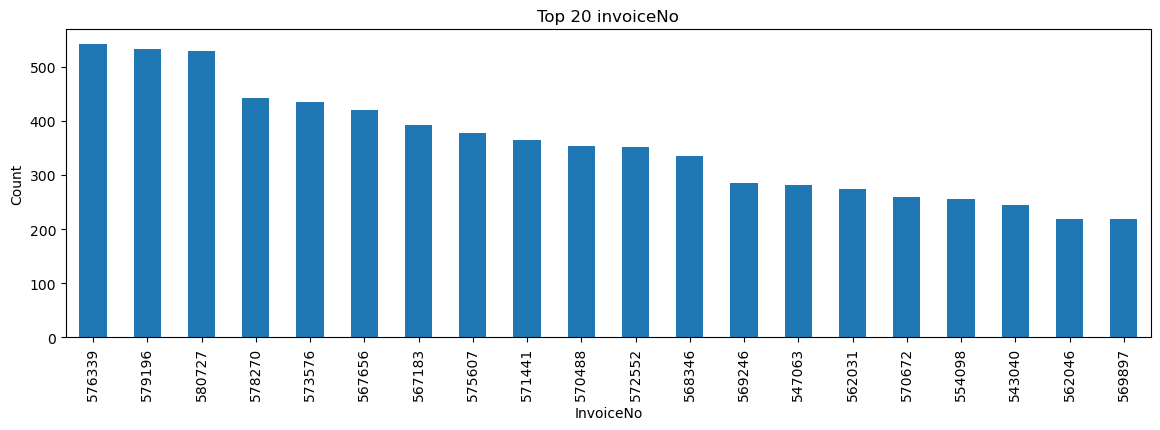

In [6]:
x = df['InvoiceNo'].value_counts()
plt.rcParams['figure.figsize'] = (14,4)
x.head(20).plot.bar()
plt.ylabel('Count')
plt.title('Top 20 invoiceNo')
plt.show()

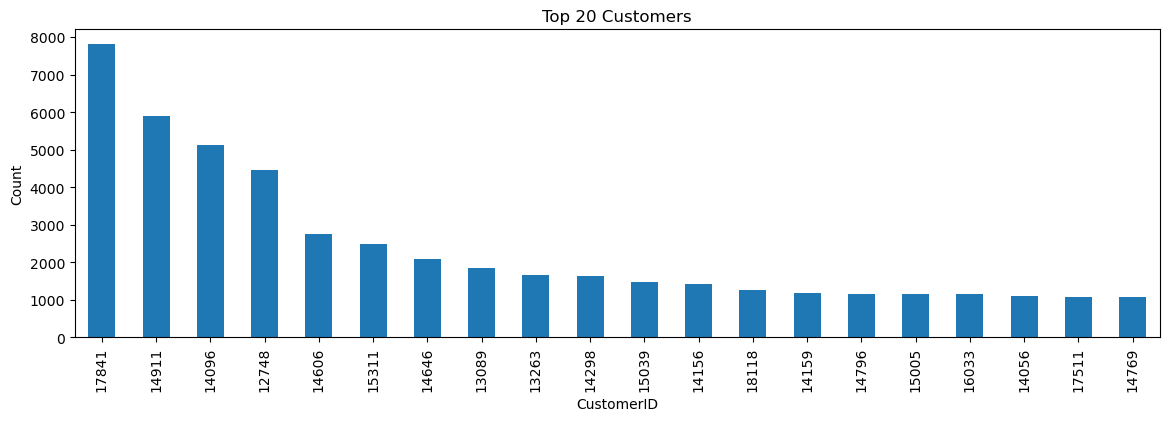

In [7]:
x = df['CustomerID'].value_counts()
plt.rcParams['figure.figsize'] = (14,4)
x.head(20).plot.bar()
plt.ylabel('Count')
plt.title('Top 20 Customers')
plt.show()

In [8]:
x = df.groupby(['CustomerID','InvoiceNo'])['price'].sum()
x = x.sort_values().reset_index().rename({'price':'total_price'},axis=1)
print(x[x['total_price'] < 0].head(50).T) # We found that InvoiceNo starts with 'C' has negative price it means the customers cancelled the orders

                   0        1        2        3        4        5        6   \
CustomerID      16446    12346    15098    15749    16029    12536    16029   
InvoiceNo     C581484  C541433  C556445  C550456  C570556  C573079  C551685   
total_price -168469.6 -77183.6 -38970.0 -22998.4 -9466.56 -8322.12 -8142.75   

                  7        8        9   ...       40       41       42  \
CustomerID     16029    12744    14911  ...    15769    12748    12757   
InvoiceNo    C551699  C571750  C562375  ...  C567706  C576831  C554302   
total_price  -6930.0 -6068.06  -4345.1  ...  -1326.0  -1301.0 -1241.98   

                  43       44       45       46       47       48       49  
CustomerID     12757    14146    14213    17404    14031    16013    14680  
InvoiceNo    C554154  C542426  C536850  C538847  C548532  C556925  C568879  
total_price -1241.98 -1241.43  -1192.2  -1188.0  -1170.0  -1155.0 -1146.07  

[3 rows x 50 columns]


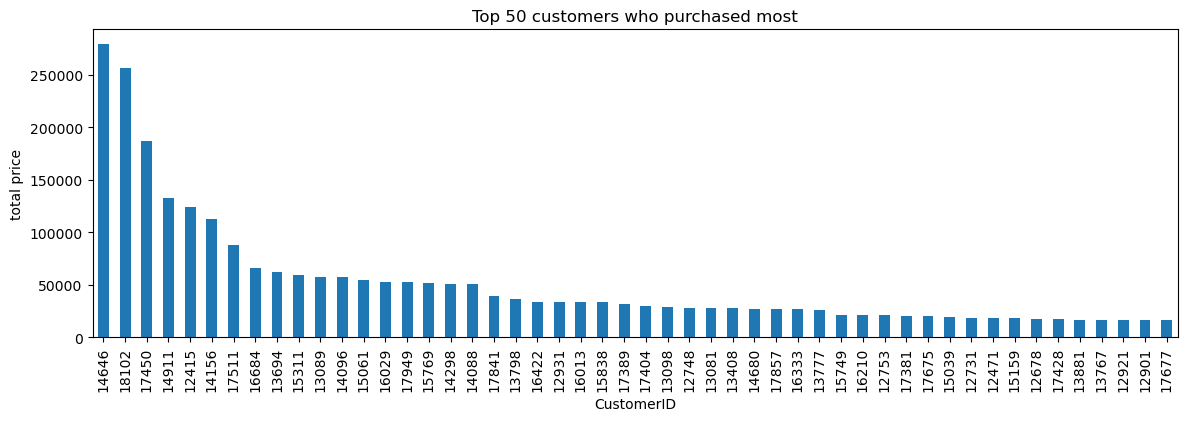

In [9]:
x = x.groupby(['CustomerID'])['total_price'].sum()
x.sort_values(ascending=False).head(50).plot.bar()
plt.title('Top 50 customers who purchased most')
plt.ylabel('total price')
plt.show()

In [10]:
regular_customers = df['CustomerID'].value_counts().reset_index() # For this project I will consider only those customer who are regular buyer
regular_customers = regular_customers[regular_customers['count'] > 5] # Considering the customers purchased more than 5 times atleast
df = df[df['CustomerID'].isin(regular_customers['CustomerID'])]
df['transformedCountry'] = df['Country'].apply(lambda x:x.replace(' ','')) # I don't want words like 'United Kingdom' to treat like two different words
df['tags'] = ' '+df['Description']+' '+df['transformedCountry']+' ' # concatening Describe and Countrya and also 1 space before and after the tags
customer_tag_df = df.groupby(['CustomerID'])['tags'].sum().reset_index() # Concatenating description for each customer together
customer_tag_df = customer_tag_df.set_index(customer_tag_df['CustomerID']).drop('CustomerID',axis=1) # Setting index and dropping CustomerID
customer_tag_df['processed_tags'] = customer_tag_df['tags']
customer_tag_df['tags'] = customer_tag_df['tags'].apply(lambda x: ' '.join(list(set(x.split())))) # Revome duplicates
customer_tag_df['processed_tags'] = customer_tag_df['processed_tags'].apply(p.preprocessing) # Textual preprocessing
# making directory for data saving
! mkdir preprocessed_data 
customer_tag_df.to_csv('./preprocessed_data/clean_data.csv') # saving the clean data in csv form

A subdirectory or file preprocessed_data already exists.


In [11]:
customer_tag_df.head()

,tags,processed_tags
CustomerID,,
12347,"PIECE PEN,COAL HOOK RABBIT FUN SUNDAE DECORATI...",black candelabra tlight holder iceland airlin ...
12348,PEN POSTAGE SUNDAE SKULL 9 GLOSS Finland DOLLY...,sweetheart fairi cake case finland cake case d...
12349,PIECE YOUR LEVEL TIDY SONGBIRD RIBBON 20 GIFT ...,parisienn curio cabinet itali sweetheart wall ...
12350,PLASTIC BAG RETRO NEIGHBOURHOOD POSTAGE FLAG T...,chocol this way metal sign norway metal sign n...
12352,PIECE FUN PEDESTAL BABY JELLY HARMONICA BLOCK ...,wooden happi birthday garland norway pink doug...
